In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#  build the dataset
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w + '.':# because here is word + '.', each word will endup with a ., that also means each word endup with ch idx=0
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])# here context has not been updated
        context = context[1:] + [ix]# this context will be printed next round
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype # dataset, input and output

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

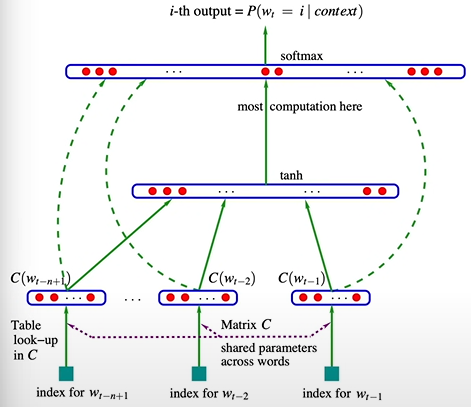

In [8]:
# the reference paper, lookup table C: 17000 words  --> 30 dimentional embedding
# our case, lookup table C: 27 charecter --> 2 dimentional embedding, init with randn
C = torch.randn((27, 2))

get the data by index the array
1. can get single data
2. can get multiple data
3. can repeatly get same data

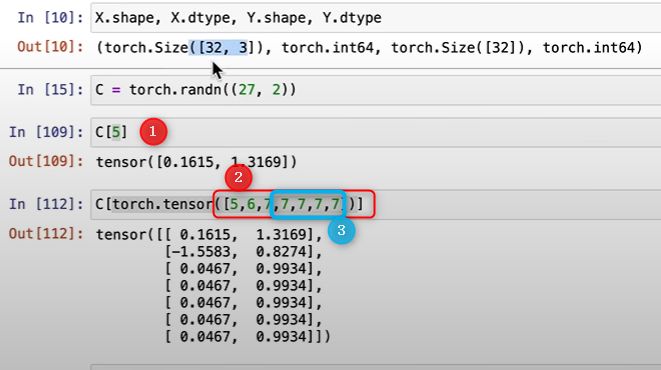




1. C[X] is same is index checking, the size ([32, 3, 2]), [32, 3] present the index matrix, the corresponding position is an index, 
   that can lookup table C to get the embeding info
2. eg. X[13, 2] means the index value at X matrix position [13, 2], we get the inded value 1
3. eg. C[X][13,2] means we firstly embedding the index matrix X, then look up the position [13, 2], we get the embeding info
4. eg. if we directly lookup the index 1, we get same value


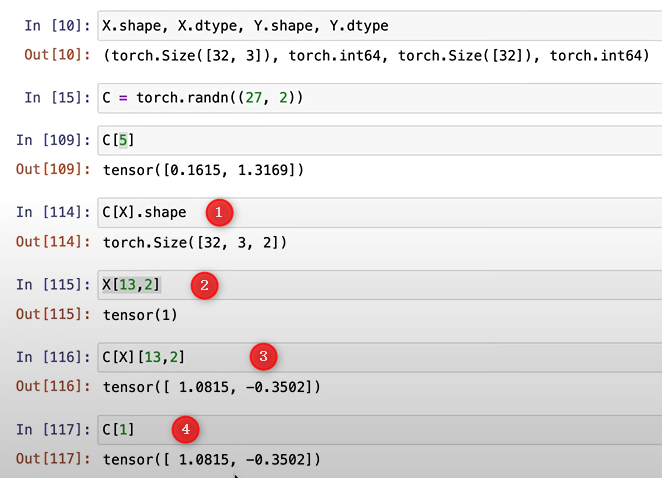



In [9]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

next step we need go to the hidden layer, tanh with 100 neurons
input is emb, output is 100 tanh neurons
because we have 3 character with 2 dimention, the emb interprete into 3*2 = 6, the hidden layer input should be (data num, 6)

for acquiring the right input shape, for eg. [32, 3, 2] to [32, 6], we need concatate the matrix --> torch.cat()
1. torch.cat() take a sequence, 2. need cat dimention, here we need dim1 (columns)

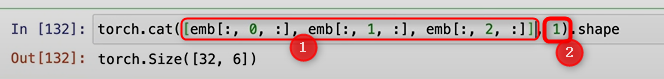

but we want auto seperate the data then cat, here comes torch.unbind to() resque
we need decide which dimention to unbined, for emb[32, 3, 2], our target is the second dim, that indexed with 1

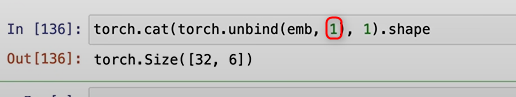

# we have more efficient way to get the same result: .view())

why .view() is more efficiency? it is because this will not create new memory, but have logical construct on the exist memory
all data behind the neath is a 1d list

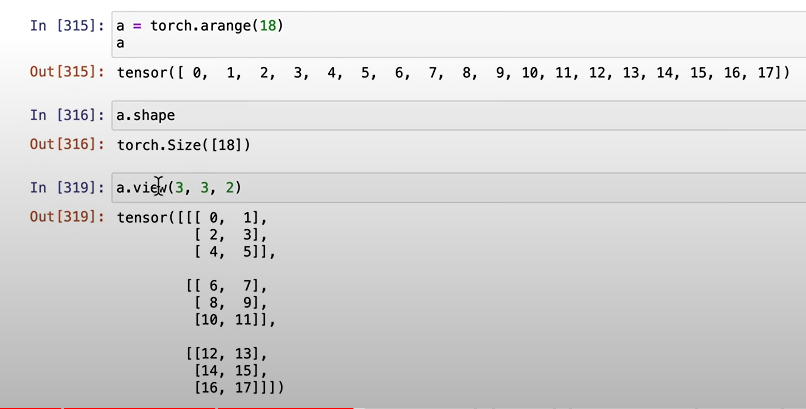

In [11]:
emb.view(32, 6).shape

torch.Size([32, 6])

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # the hidden layer, with tanh, the date squashed into (-1, 1)
#  also pay attention to broadcasting: emb.shape[0], 6) @ W1 and b1
#  32, 100
#  1, 100
#  for the not equal dim, it will copy, that is what we want

In [15]:
#  the final layer
W2 = torch.randn((100, 27)) # from the 100 neuron output to 27 characters final result
b2 = torch.randn(27)

In [16]:
logits = h @ W2 + b2

calculate the 27 char probability
1. counts = logits.exp() --> make all date position, so we can see them as counter
2. prob = counts / counts.sum(1, keepdims = True) --> for each row, that means all 27 char counters, have single character normalization

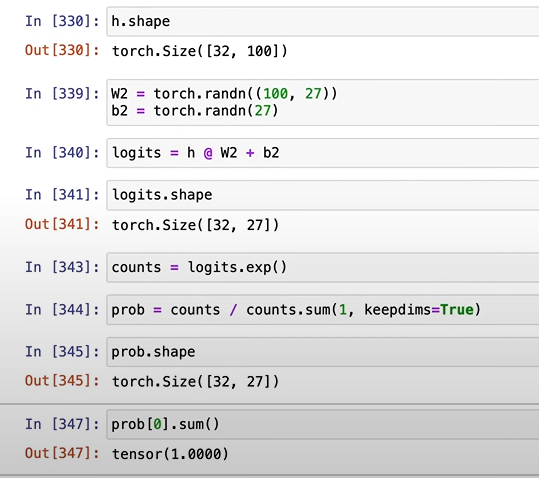

Y is the target output charactor identity, for each data, have one index, with the index, combine with input row, we get prob value
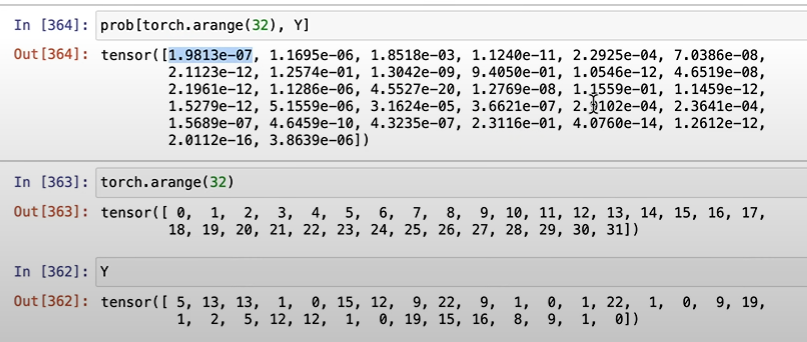

with prob value, we can calculate loss

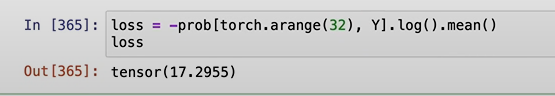


In [17]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [21]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]


In [22]:
sum(p.nelement() for p in parameters)

3481

In [24]:
emb = C[X] # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 +b1)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
#  from counts to loss can be summarized into F.cross_entropy(logits, Y)
F.cross_entropy(logits, Y)


tensor(17.7697)

tensor(17.7697)